# Features Selection For b278 VVV Tile

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [1]:
% matplotlib inline

import os

import numpy as np

import pandas as pd

import sh

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

from IPython import display as d
from IPython.display import Audio

from wand.image import Image as WImage

import pytff

from libs import fourier_help

pd.options.mode.chained_assignment = None 

def alert():
    sound_file = 'data/alert.wav'
    try:
        sh.play(sound_file)
    except:
        pass

## The Data
- All the features of the b278 tile are stored inside the table `b278` of the *data/features.h5* file
- This file is an standar [hdf5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format#HDF5) format and can be
  acceded from a diferent languages. Also the HDF group offers some interesting projects like; [hdf5 command line tools](https://support.hdfgroup.org/products/hdf5_tools/) (like *h5ls*), and [hdfview](https://support.hdfgroup.org/products/java/hdfview/) (A Java based visual explorer)
- In this notebook we use the [Pandas Library](http://pandas.pydata.org/) to acces and retrieve the full table as a dataframe.

In [2]:
df = pd.read_hdf("data/features.h5", "b278")
df.head()

,vvv_id,cls,Amplitude,Rcs,StetsonK,Meanvariance,Autocor_length,StetsonK_AC,Con,Beyond1Std,...,A_1,phi_1,A_2,phi_2,A_3,phi_3,A_4,phi_4,A_5,phi_5
0,3656246,-1,0.42050,0.396656,0.784434,0.013916,7.0,NaN,0.000000,0.303030,...,0.2133,5.2027,0.0529,0.9508,0.0,0.0,0.0,0.0,0.0,0.0
1,3656321,-1,0.28150,0.402302,0.795058,0.009853,6.0,NaN,0.000000,0.250000,...,0.1274,0.9561,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,3656324,-1,1.06800,0.394377,0.802921,0.046222,6.0,NaN,0.000000,0.218750,...,0.6657,0.0916,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,3656358,-1,0.74125,0.332390,0.665459,0.029095,3.0,NaN,0.034483,0.129032,...,0.3589,0.0136,0.1808,4.7505,0.0,0.0,0.0,0.0,0.0,0.0
4,3656363,-1,0.76475,0.374359,0.756028,0.029772,5.0,NaN,0.000000,0.194444,...,0.4192,3.2536,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


## Features

- Every row of the dataframe is a resume of the lightcurve of some source of the Tile.
- The special columns are:
    - `vvv_id`: The identification of this source inside our databse.
    - `cls`: The Rrlyrae class identified from the [OGLE Survey](https://en.wikipedia.org/wiki/Optical_Gravitational_Lensing_Experiment) where: 
      - **-1** is unknow or is not an RRLyrae  or variable Star
      - **1** is [RRLyrarAB](https://en.wikipedia.org/wiki/RR_Lyrae)
      - **2** is [RRLyrarC]
      - **3** is [RRLyrarD]
- The `b278` table contains ~70 features obtained with 2 workflows.
  1. Features created with [Feature Analysis for Time Series (FATS) Library](https://github.com/isadoranun/FATS) 
      - The first Workflows generates all columns except `gatspy_period` and all the `A_*` and `phi_*`
      - All the FATS features are documented here:
        http://isadoranun.github.io/tsfeat/FeaturesDocumentation.html#The-features
  2. The features:
      - `gatspy_period`: are a period calculated with the 
        [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) 
        of the [Gatspy Library](http://www.astroml.org/gatspy/)
      - `A_*` and `phi_*`: Are the fourier components calculated with the 
        [Template Fourier Fitting](http://www.konkoly.hu/staff/kovacs/tff.html) algorithm with the
        [pytff lybrary](https://github.com/carpyncho/pytff) asumming the `gatspy_period` as real period.

In [4]:
if "period_diff" not in df.columns:
    df["period_diff"] = np.abs(df.PeriodLS - df.gatspy_period)
    
nv = df[df.cls == -1]
rr = df[df.cls != -1]

#### Comparison between FATS and Gatspy Periods

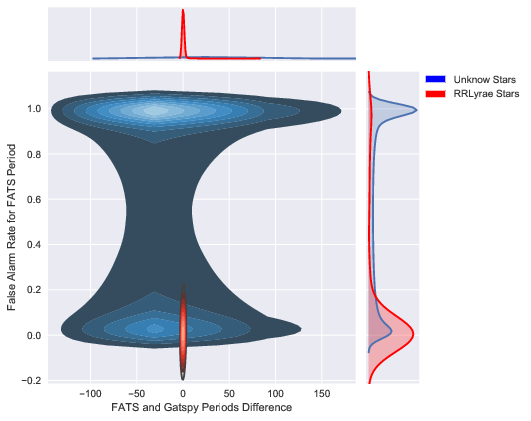

In [5]:
def show_period_comparison():
    path = "figures/periods_comparison.pdf"
    if not os.path.exists(path):
        g = sns.jointplot(
            kind="kde", x=nv.period_diff, y=nv.Period_fit, 
            cmap="Blues_d", shade_lowest=True)
        g.ax_joint.collections[0].set_alpha(0)
        
        g.x = rr.period_diff
        g.y = rr.Period_fit
        g = g.plot_joint(
            sns.kdeplot, marker='x', shade_lowest=True, cmap='Reds_d')        
        g = g.plot_marginals(sns.kdeplot, color="r", shade=True)

        g.ax_joint.legend_.remove()
        g.ax_marg_x.legend_.remove()
        g.ax_marg_y.legend_.remove()

        g.ax_joint.set_xlim(
            nv.period_diff.mean() - nv.period_diff.std() * 0.36, 
            nv.period_diff.mean() + nv.period_diff.std() * 0.3)

        g.ax_joint.set_ylim(
            nv.Period_fit.mean() - nv.Period_fit.std() * 2, 
            nv.Period_fit.mean() + nv.Period_fit.std() * 1.5)

        g.set_axis_labels(
            "FATS and Gatspy Periods Difference", 
            "False Alarm Rate for FATS Period")

        legends = plt.legend(
            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
            handles=[
                mpatches.Patch(color='blue', label='Unknow Stars'),
                mpatches.Patch(color='red', label='RRLyrae Stars')])
        plt.savefig(
            path, format="pdf", dpi=150, 
            bbox_extra_artists=[legends], bbox_inches='tight')
        plt.close()
        alert()
    return WImage(filename=path)
    

d.display(d.Markdown("#### Comparison between FATS and Gatspy Periods"))
show_period_comparison()

In [6]:
def get_fourier_diff():
    nv_path, rr_path = (
        "cache/fourier_diff_nv.pkl", 
        "cache/fourier_diff_rr.pkl")
    if not os.path.exists(nv_path) or not os.path.exists(rr_path):
        print "calculating"
        params = {"start": 0, "stop": 1, "num": 100}

        def series_creator(src):
            kc_data = fourier_help.fourier_data(src, "kovacs")
            kc_x, kc_y = pytff.fspace(kc_data, **params)

            fats_data = fourier_help.fourier_data(src, "FATS")
            fats_x, fats_y = pytff.fspace(fats_data, **params)

            diff = np.abs(kc_y - fats_y)
            diff_sum = diff.sum()
            for idx in range(params["num"]):
                pulled = np.roll(fats_y, idx)
                pull_diff = np.abs(kc_y - pulled)
                pull_diff_sum = pull_diff.sum()
                if pull_diff_sum < diff_sum:
                    diff, diff_sum = pull_diff, pull_diff_sum
            data = {"eps": diff_sum}
            
            for i, xy in enumerate(zip(kc_x, diff)):
                x, y = xy
                data["diff_x_{}".format(i)] = x
                data["diff_y_{}".format(i)] = y
            
            return pd.Series(data)
        
        signal_nv = nv.apply(series_creator, axis=1)
        signal_nv.to_pickle(nv_path)
        
        signal_rr = rr.apply(series_creator, axis=1)
        signal_rr.to_pickle(rr_path)
        alert()        
    return pd.read_pickle(nv_path), pd.read_pickle(rr_path)
    
signal_nv, signal_rr = get_fourier_diff()
del df

#### Comparison between FFATS and Kovacs-Kupi Fourier Signals

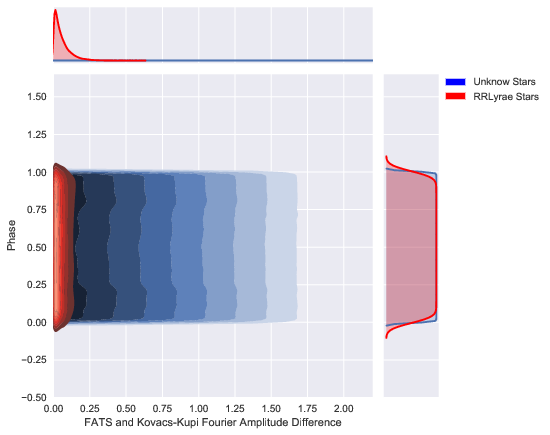

In [7]:
x_c = [c for c in signal_nv.columns if c.startswith("diff_x_")]
y_c = [c for c in signal_nv.columns if c.startswith("diff_y_")]
xs = signal_nv.sample()[x_c].values

rr_xs = np.tile(xs, (signal_rr.shape[0], 1))
rr_ys = signal_rr[y_c].values 

nv_xs = np.tile(xs, (signal_nv.shape[0], 1))
nv_ys = signal_nv[y_c].values 

del signal_nv, signal_rr

def show_fourier_comparison():
    path = "figures/fourier_comparison.pdf"
    if not os.path.exists(path):

        print "calculating"

        g = sns.jointplot(kind="kde", x=nv_ys, y=nv_xs, shade=True)
        g.ax_joint.collections[0].set_alpha(0)

        g.x = rr_ys.ravel()
        g.y = rr_xs.ravel()
        g = g.plot_joint(sns.kdeplot, marker='x', cmap='Reds_d', 
                         shade=True, shade_lowest=False)
        g = g.plot_marginals(sns.kdeplot, color="r", shade=True)

        g.ax_joint.legend_.remove()

        g.ax_joint.set_xlim(0, 2.2)
        g.ax_joint.set_ylim(-0.5, 1.65)

        g.ax_joint.set_xlabel("FATS and Kovacs-Kupi Fourier Amplitude Difference")
        g.ax_joint.set_ylabel("Phase")

        legends = plt.legend(
            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
            handles=[
                mpatches.Patch(color='blue', label='Unknow Stars'),
                mpatches.Patch(color='red', label='RRLyrae Stars')])
        plt.savefig(
            path, format="pdf", dpi=150, 
            bbox_extra_artists=[legends], bbox_inches='tight')
        plt.close()
        alert()
    return WImage(filename=path)
    
    
d.display(d.Markdown("#### Comparison between FFATS and Kovacs-Kupi Fourier Signals"))
show_fourier_comparison()    

In [10]:
def get_eps():
    path = "cache/eps.npz"
    if not os.path.exists(path):
        eps_nv, eps_rr = [
            np.nan_to_num(signal.eps.values) 
            for signal in get_fourier_diff()]
        np.savez(path, eps_nv=eps_nv, eps_rr=eps_rr)
    npzfile = np.load(path)
    return npzfile["eps_nv"], npzfile["eps_rr"]
    
eps_nv, eps_rr = get_eps()    

#### Comparision between FATS and Kovacs-Kupi $min(\epsilon$)

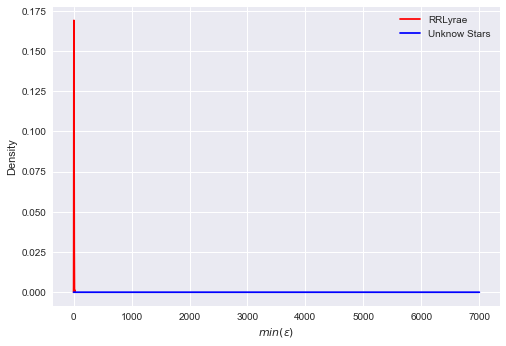

In [12]:
path = "figures/eps_comparison.pdf"
ax = sns.kdeplot(eps_rr, color="r", label="RRLyrae")
sns.kdeplot(eps_nv, color="b", label="Unknow Stars", ax=ax)

ax.set_xlabel("$min(\epsilon)$")
ax.set_ylabel("Density")
d.display(d.Markdown("#### Comparision between FATS and Kovacs-Kupi $min(\epsilon$)"))
plt.savefig(
        path, format="pdf", dpi=150, bbox_inches='tight')
plt.show()